# UNET Class and other pre-requisites to load the model here

In [ ]:
import torch
import torch.nn as nn #imports necessary neural network toolbox
import torch.nn.functional as nnfunc 

class DoubleConv(nn.Module):
    """
    Double Convolution Block - Basic building block of U-Net
    Pattern: Conv -> BatchNorm -> ReLU -> Conv -> BatchNorm -> ReLU
    """
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),#the first convolution of the double conv.
            nn.BatchNorm2d(out_channels),
            # batch norm will help normalise the effects of activation functions
            # so that the model will be more stable and fast as per Geek4Geeks.
            nn.ReLU(inplace=True), # <- the activation function
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1), #second convolution
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, tensor):
        """
        This confused me initially, I thought that the code under def__init__
        would be enough, but according to Geeks4Geeks: 
        https://www.geeksforgeeks.org/deep-learning/understanding-the-forward-function-output-in-pytorch/
        
        The forward method is PyTorch's implementation of a forward pass:
        that's when the data/tensor is passed through the model
        """
        return self.double_conv(tensor)

class UNET(nn.Module):
    """
    U-Net Architecture for Medical Image Segmentation
    encoder (Downsampling):  Input -> Conv -> Pool -> Conv -> Pool -> bottleneck
    decoder (Upsampling):    bottleneck -> Upsample -> Concat -> Conv -> ... -> Output
    skip connections: Connect encoder features directly to decoder for fine details
    """
    def __init__(self, in_channels, out_channels):
        super(UNET, self).__init__() 
        """
        A super().__init__() is necessary to initialise the base nn.Module 
        so that dependencies and everything works for neural networks in PyTorch
        
        Args:
            in_channels: number of input channels, 1 for grayscale
            out_channels: number of output channels, 1 for binary segmentation
            
        The U-Net paper has the following encoder implementation:
        1) Double conv (64 channels)
        2) Max pool 2x2 + Double conv (128 chnnels)  
        3) Max pool 2x2 + Double conv (256 chanels)
        4) Max pool 2x2 + Double conv (512 channls)
        5) Max pool 2x2 + Double conv (1024 chanels)
        
        Using this, there are 5 different double conv operations
        but we reuse the same max pool operation because the double conv
        has to account for changes in channel dimensions
        """
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)  # halves spatial dimensions
        
        # encoder path (Contracting/Downsampling)
        # Each step: DoubleConv -> MaxPool (except bottleneck)
        self.dconv1 = DoubleConv(in_channels, 64)   # Input -> 64 channes   (128x128 -> 128x128)
        self.dconv2 = DoubleConv(64, 128)           # 64 -> 128 channels     (64x64 -> 64x64)
        self.dconv3 = DoubleConv(128, 256)          # 128 -> 256 chanels    (32x32 -> 32x32)
        self.dconv4 = DoubleConv(256, 512)          # 256 -> 512 chanels    (16x16 -> 16x16)
        self.dconv5 = DoubleConv(512, 1024)         # 512 -> 1024 chanels   (8x8 -> 8x8) bottleneck
        
        # decoder path (Expanding/Upsampling)
        # these are the variables for the decoder - upsampling is the opposite of max pooling
        
        # Level 4: from bottleneck (1024 ch, 8x8) -> Level 4 encoder (512 ch, 16x16)
        self.upsample4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)  # 8x8 -> 16x16
        self.upconv4 = DoubleConv(1024, 512)  # 1024 channels (512+512 from skip) -> 512
        
        # Level 3: from level 4 (512 ch, 16x16) -> Level 3 encoder (256 ch, 32x32)  
        self.upsample3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)   # 16x16 -> 32x32
        self.upconv3 = DoubleConv(512, 256)   # 512 channels (256+256 from skip) -> 256
        
        # Level 2: from level 3 (256 ch, 32x32) -> Level 2 encoder (128 ch, 64x64)
        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)   # 32x32 -> 64x64
        self.upconv2 = DoubleConv(256, 128)   # 256 channels (128+128 from skip) -> 128
        
        # Level 1: from level 2 (128 ch, 64x64) -> Level 1 encoder (64 ch, 128x128)
        self.upsample1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)    # 64x64 -> 128x128
        self.upconv1 = DoubleConv(128, 64)    # 128 channels (64+64 from skip) -> 64
        
        # OUTPUT LAYER
        # after this the last step is one final 1x1 conv layer
        self.outconv = nn.Conv2d(64, 1, kernel_size=1)  # 64 -> 1 channel (segmentation mask)
    
    def _concat(self, up_tensor, skip_tensor):
        """
        Concatenate upsampled tensor with skip connection from encoder.
        handle size mismatches by padding the smaller tensor.
        
        Skip connections are crucial because they:
        1. Preserve fine spatial details lost during downsampling
        2. Help gradients flow better during backpropagation  
        3. Combine low-level features (edges) with high-level features (semantics)
        """
        # Check if spatial dimensions match between upsampled and skip tensors
        if up_tensor.size(2) != skip_tensor.size(2) or up_tensor.size(3) != skip_tensor.size(3):
            # Calculate differences in Height and Width
            y_ax_diff = skip_tensor.size(2) - up_tensor.size(2)  # height difference
            x_ax_diff = skip_tensor.size(3) - up_tensor.size(3)  # width difference

            # Pad order in F.pad = [left, right, top, bottom]
            # Distribute padding evenly, with extra pixels on right/bottom if odd
            up_tensor = nnfunc.pad(
                up_tensor,
                [x_ax_diff // 2, x_ax_diff - x_ax_diff // 2,   # [left, right]
                 y_ax_diff // 2, y_ax_diff - y_ax_diff // 2]   # [top, bottom]
            )
        
        # concatenate along channel dimension (dim=1)
        # noting that tensor format: [batch, channel, height, width]
        # result: channels = skip_channels + up_channels
        return torch.cat([skip_tensor, up_tensor], dim=1)
    
    def forward(self, tensor):
        """
        Forward pass through U-Net
        
        Data Flow:
        Input -> encoder (extract features) -> bottleneck -> decoder (reconstruct) -> Output
        
        Skip connections preserve spatial information lost during downsampling
        
        input tensor shape: (batch_size, channels, height, width)
        echocardiograms frames: (batch_size, 1, 112, 112)
        """
        
        # encoder path (steps 1-9) - Extract features at multiple scales
        # save encoder outputs for skip connections (step1, step3, step5, step7)
        
        
        step1 = self.dconv1(tensor)           # Input(B,1,112,112) -> (B,64,112,112)
        step2 = self.max_pool(step1)          # (B,64,112,112) -> (B,64,56,56)
        
        step3 = self.dconv2(step2)            # (B,64,56,56) -> (B,128,56,56)  
        step4 = self.max_pool(step3)          # (B,128,56,56) -> (B,128,28,28)
        
        step5 = self.dconv3(step4)            # (B,128,28,28) -> (B,256,28,28)
        step6 = self.max_pool(step5)          # (B,256,28,28) -> (B,256,14,14)
        
        step7 = self.dconv4(step6)            # (B,256,14,14) -> (B,512,14,14)
        step8 = self.max_pool(step7)          # (B,512,14,14) -> (B,512,7,7)
        
        step9 = self.dconv5(step8)            # (B,512,7,7) -> (B,1024,7,7) bottleneck
        
        # decoder PATH - Reconstruct spatial resolution with skip connections
        # Each step: Upsample -> Concatenate with encoder -> Process with DoubleConv
        
        # Level 4: Combine bottleneck with encoder level 4 (step7)
        step10 = self.upsample4(step9)        # (B,1024,7,7) -> (B,512,14,14)
        step11 = self._concat(step10, step7)  # Concat: (B,512,14,14) + (B,512,14,14) -> (B,1024,14,14)
        step12 = self.upconv4(step11)         # (B,1024,14,14) -> (B,512,14,14)

        # Level 3: Combine with encoder level 3 (step5) 
        step13 = self.upsample3(step12)       # (B,512,14,14) -> (B,256,28,28)
        step14 = self._concat(step13, step5)  # Concat: (B,256,28,28) + (B,256,28,28) -> (B,512,28,28)
        step15 = self.upconv3(step14)         # (B,512,28,28) -> (B,256,28,28)

        # Level 2: Combine with encoder level 2 (step3)
        step16 = self.upsample2(step15)       # (B,256,28,28) -> (B,128,56,56)
        step17 = self._concat(step16, step3)  # Concat: (B,128,56,56) + (B,128,56,56) -> (B,256,56,56)
        step18 = self.upconv2(step17)         # (B,256,56,56) -> (B,128,56,56)

        # Level 1: Final upsampling to original resolution, combine with step1
        step19 = self.upsample1(step18)       # (B,128,56,56) -> (B,64,112,112)
        step20 = self._concat(step19, step1)  # Concat: (B,64,112,112) + (B,64,112,112) -> (B,128,112,112)
        step21 = self.upconv1(step20)         # (B,128,112,112) -> (B,64,112,112)

        # output - Map feature channels to segmentation mask
        # Returns raw logits (before sigmoid) - loss function will handle this
        return self.outconv(step21)           # (B,64,112,112) -> (B,1,112,112)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def dice_coeff(predictions, targets, smooth=1e-6):
    """
    no dice loss function in pytorch
    args:
        predictions: Sigmoid probabilities [0,1] 
        targets: Binary ground truth [0,1]
        smooth: Smoothing factor to avoid division by zero
    returns:
        dice_score: Float between 0 and 1
    """
    # Flatten tensors for easier calculation
    pred_flat = predictions.reshape(-1)
    target_flat = targets.reshape(-1)
    
    # Calculate intersection (overlap)
    intersection = (pred_flat * target_flat).sum()
    
    # Calculate union (total covered area)
    union = pred_flat.sum() + target_flat.sum()
    
    # Dice coefficient: 2 * intersection / union
    dice = (2.0 * intersection + smooth) / (union + smooth)
    
    return dice


def CombinedBCEDiceLoss(predictions, targets, bce_weight=0.5, dice_weight=0.5):
    '''
    Combined BCE + Dice Loss for binary segmentation
    args:
        1.predictions (torch.Tensor): the raww model outputs (logits) from U-Net
            - expecting shape: (batch_size, 1, height, width) 
            
        2.targets (torch.Tensor): the ground truth binary masks
            - shape: (batch_size, 1, height, width) - same as predictions
            
        3. bce_weight (float):weighting for the bce component, set to 0.5 for equal weight with dice
            - BCE is good at: sharp boundaries, overall pixel classification
            
        4. dice_weight (float): weighting for the dice component, set to 0.5
            - Dice is good at: handling class imbalance, shape preservation
    
    returns:
        tuple: (combined_loss, bce_component, dice_component)
            - combined_loss (torch.Tensor): Weighted sum for backpropagation
            - bce_component (float): BCE loss value for monitoring
            - dice_component (float): Dice loss value for monitoring
    '''
    # BCE part
    bce_loss = nn.BCEWithLogitsLoss()(predictions, targets)
    
    # Dice part
    predictions_sigmoid = torch.sigmoid(predictions)  #using sigmoid function to perform binary classification of the pixels
    dice_score = dice_coeff(predictions_sigmoid, targets) #compares the predictions agains the ground truth
    dice_loss = 1.0 - dice_score
    
    # Combined loss
    combined_loss = (bce_weight * bce_loss) + (dice_weight * dice_loss)
    
    return combined_loss, bce_loss.item(), dice_loss.item()


In [ ]:
# Set device for computation (GPU if available, else CPU)
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Model First:
def load_trained_model(path="best_unet_adamw_cosine.pt"):  # Fixed typo in filename
    """Load the trained U-Net model from checkpoint"""
    model = UNET(1, 1).to(device)
    
    if os.path.exists(path):  # Check if model exists
        try:
            checkpoint = torch.load(path, map_location=device, weights_only=False)
            model.load_state_dict(checkpoint['model_state_dict'])
            print("Model loaded")
            model.eval()
            return model, checkpoint
        except Exception as e:
            print("Model not loaded")
            return None, None
    else:
        print("Error")
        return None, None




In [ ]:
# Make sure to load the trained model first -- see code above
# Train on the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

from pathlib import Path

def predict_one_folder(model, folder, threshold=0.5):
    '''
    Use this to predict 1 folder first to see the results, and prototype the video output

    args: 
        model: UNET(in_chan, out_chan)
        folder: the path to the folder for prediction-- use test folder instead of train/val
        threshold: threshold for binary pred set to 0.5

    returns: a dictionary called predictions
        frame: framename relating to the predicted frame
        frame_image: the original frame image
        mask: binary mask as numpy arrays (just like how original segmentation mask was created)
        pixel_count: pixel count for the mask
    '''
    folder = Path(folder)
    frame_paths = sorted(folder.glob("*.png")) # look for .png files in the specified folder

    predictions = {
        'frame': [],           # framename 
        'frame_image': [],     # frameimage
        'mask': [],            # binary mask
        'pixel_count': []      # pixel count for the mask
    }
    model.eval()

    with torch.no_grad(): # disable backprop
        for frame_path in frame_paths:
            try:
                # loading the original frame
                frame = cv2.imread(str(frame_path), cv2.IMREAD_GRAYSCALE) # specifying that it's grayscale

                # Normalise to [0,1] for gradient stability, and to help the sigmoid act function to work with the threshold of 0.5
                frame_normalised = frame.astype(np.float32)/255.0
                frame_tensor = torch.from_numpy(frame_normalised) # creates tensor shape (112, 112) corresp to H*W
                frame_tensor = frame_tensor.unsqueeze(0) # add channel dim, = 1 so shape is (1,112,112)
                frame_tensor = frame_tensor.unsqueeze(0) # add batch dim, so shape is (1,1,112,112)
                frame_tensor = frame_tensor.to(device) # use GPU

                # run the model to output logits which are just raw numbers
                with torch.amp.autocast(device_type=device.type, enabled=(device.type=="cuda")):
                    logits = model(frame_tensor) # creates raw logits
                    probs = torch.sigmoid(logits) # after sigmoid it changes this to [0,1]
                    binary_mask = (probs > threshold).float() # apply the 0.5 threshold

                mask_np = binary_mask.squeeze().cpu().numpy()  # Move to CPU first, then convert
                pixel_count = int(np.sum(mask_np))

                # store the result of each frame in frame_path in the dict.
                predictions['frame'].append(frame_path.name)         # filename
                predictions['frame_image'].append(frame)             # original image (112x112)
                predictions['mask'].append(mask_np)                  # binary mask (112x112)
                predictions['pixel_count'].append(pixel_count)       # pix count for later

            except Exception:
                print("error")
                break

    return predictions

# Code to Calculate LVEF per video here

Model loaded
✅ Model loaded successfully!
Found 10030 video directories
Processing ALL 10030 videos with pixel filtering...


Processing videos: 100%|██████████| 10030/10030 [4:15:42<00:00,  1.53s/it] 



📊 FILTERING SUMMARY:
   Videos processed: 10030
   Videos filtered out: 0
   Pixel threshold used: 75

✅ Successfully processed 10030 videos

Sample results:
                  Key  Min_pixel  Max_pixel  EF_pixel       ESV_frame  \
0  0X100009310A3BD7FC        592       1411     58.04  frame_0021.png   
1  0X1002E8FBACD08477        618       1241     50.20  frame_0187.png   
2  0X1005D03EED19C65B        503       1055     52.32  frame_0037.png   
3  0X10075961BC11C88E        700       1249     43.96  frame_0077.png   
4  0X10094BA0A028EAC3       1571       2322     32.34  frame_0064.png   

        EDV_frame  total_frames  valid_frames  filtered_frames  \
0  frame_0043.png           174           174                0   
1  frame_0048.png           215           215                0   
2  frame_0098.png           104           104                0   
3  frame_0000.png           122           122                0   
4  frame_0175.png           207           207                0   

   mi

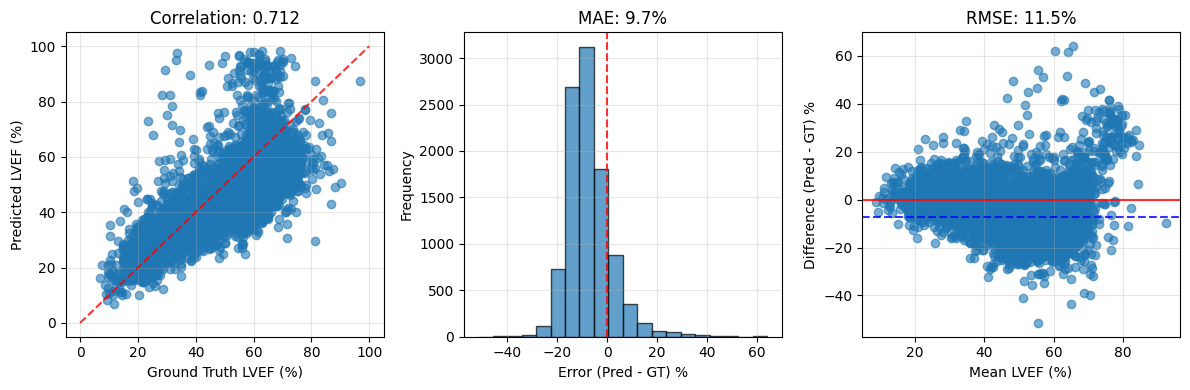


📈 PERFORMANCE METRICS:
   MAE (Mean Absolute Error): 9.69%
   RMSE (Root Mean Square Error): 11.48%
   Correlation: 0.712
   Bias (mean error): -7.14%
💾 Filtered comparison results saved


In [14]:
# Add missing imports
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import torch
import cv2
import numpy as np
import os

# 1. First, load your trained model
loaded_model, checkpoint_info = load_trained_model("best_unet_adamw_cosine.pt")

def calculate_lvef_from_predictions(predictions, min_pixel_threshold=75):
    """
    Calculate LVEF from pixel counts, filtering out frames with low pixel counts
    
    Args:
        predictions: Dictionary with prediction results
        min_pixel_threshold: Minimum pixel count to consider (default: 75)
    """
    if not predictions or len(predictions['pixel_count']) < 2:
        return None
    
    pixel_counts = np.array(predictions['pixel_count'])
    
    # Filter out pixel counts below threshold
    valid_indices = pixel_counts >= min_pixel_threshold
    
    if np.sum(valid_indices) < 2:  # Need at least 2 valid frames
        print(f"⚠️ Warning: Only {np.sum(valid_indices)} frames above {min_pixel_threshold} pixels")
        return None
    
    # Get valid pixel counts and their corresponding indices
    valid_pixel_counts = pixel_counts[valid_indices]
    valid_frame_indices = np.where(valid_indices)[0]
    
    # Find ESV (minimum) and EDV (maximum) from valid frames only
    esv_pixel = np.min(valid_pixel_counts)
    esv_valid_index = np.argmin(valid_pixel_counts)
    esv_frame_index = valid_frame_indices[esv_valid_index]
    
    edv_pixel = np.max(valid_pixel_counts)
    edv_valid_index = np.argmax(valid_pixel_counts)
    edv_frame_index = valid_frame_indices[edv_valid_index]
    
    if edv_pixel > 0:
        lvef_pixel = ((edv_pixel - esv_pixel) / edv_pixel) * 100
    else:
        lvef_pixel = 0
    
    # Additional info about filtering
    total_frames = len(predictions['frame'])
    valid_frames = np.sum(valid_indices)
    filtered_frames = total_frames - valid_frames
    
    return {
        'ESV_pixel': int(esv_pixel),
        'EDV_pixel': int(edv_pixel),
        'LVEF_pixel': round(lvef_pixel, 2),
        'ESV_frame': predictions['frame'][esv_frame_index],
        'EDV_frame': predictions['frame'][edv_frame_index],
        'total_frames': total_frames,
        'valid_frames': valid_frames,
        'filtered_frames': filtered_frames,
        'min_threshold': min_pixel_threshold
    }

def predict_one_fast(model, folder, threshold=0.5, batch_size=16):
    """
    Fast batch processing version of predict_one_folder
    
    Args:
        model: Trained U-Net model
        folder: Path to folder containing PNG frames
        threshold: Binary threshold (default: 0.5)
        batch_size: Number of frames to process at once
    
    Returns:
        Dictionary with predictions for all frames
    """
    import cv2
    import numpy as np
    from pathlib import Path
    
    folder = Path(folder)
    frame_paths = sorted(folder.glob("*.png"))
    
    if len(frame_paths) == 0:
        return {'frame': [], 'frame_image': [], 'mask': [], 'pixel_count': []}
    
    predictions = {
        'frame': [],
        'frame_image': [],
        'mask': [],
        'pixel_count': []
    }
    
    model.eval()
    
    with torch.no_grad():
        # Process frames in batches
        for i in range(0, len(frame_paths), batch_size):
            batch_paths = frame_paths[i:i + batch_size]
            batch_frames = []
            batch_originals = []
            
            # Load batch of frames
            for frame_path in batch_paths:
                try:
                    frame = cv2.imread(str(frame_path), cv2.IMREAD_GRAYSCALE)
                    if frame is None:
                        continue
                    
                    batch_originals.append(frame)
                    
                    # Normalize and prepare tensor
                    frame_normalized = frame.astype(np.float32) / 255.0
                    frame_tensor = torch.from_numpy(frame_normalized).unsqueeze(0)  # Add channel dim
                    batch_frames.append(frame_tensor)
                    
                except Exception as e:
                    print(f"Error loading {frame_path}: {e}")
                    continue
            
            if not batch_frames:
                continue
            
            # Stack into batch tensor
            batch_tensor = torch.stack(batch_frames).to(device)  # Shape: (batch_size, 1, 112, 112)
            
            # Run inference
            with torch.amp.autocast(device_type=device.type, enabled=(device.type=="cuda")):
                logits = model(batch_tensor)
                probs = torch.sigmoid(logits)
                binary_masks = (probs > threshold).float()
            
            # Process results
            for j, (frame_path, original_frame) in enumerate(zip(batch_paths[:len(batch_frames)], batch_originals)):
                mask_np = binary_masks[j, 0].cpu().numpy()  # Remove batch and channel dims
                pixel_count = int(np.sum(mask_np))
                
                predictions['frame'].append(frame_path.name)
                predictions['frame_image'].append(original_frame)
                predictions['mask'].append(mask_np)
                predictions['pixel_count'].append(pixel_count)
    
    return predictions

def process_multiple_videos_fast(video_directories, model, batch_size=16, min_pixel_threshold=75):
    """
    Process multiple videos efficiently with pixel filtering
    
    Args:
        video_directories: List of video directory paths
        model: Trained U-Net model
        batch_size: Batch size for processing
        min_pixel_threshold: Minimum pixel count to consider valid frames
    """
    results = []
    filtered_videos = 0
    
    for video_dir in tqdm(video_directories, desc="Processing videos"):
        try:
            # Use fast batch processing
            predictions = predict_one_fast(model, video_dir, threshold=0.5, batch_size=batch_size)
            
            if not predictions or len(predictions['pixel_count']) == 0:
                continue
            
            # Apply pixel filtering
            lvef_results = calculate_lvef_from_predictions(predictions, min_pixel_threshold)
            if lvef_results is None:
                filtered_videos += 1
                continue
            
            video_id = Path(video_dir).name
            result_row = {
                'Key': video_id,
                'Min_pixel': lvef_results['ESV_pixel'],
                'Max_pixel': lvef_results['EDV_pixel'],
                'EF_pixel': lvef_results['LVEF_pixel'],
                'ESV_frame': lvef_results['ESV_frame'],
                'EDV_frame': lvef_results['EDV_frame'],
                'total_frames': lvef_results['total_frames'],
                'valid_frames': lvef_results['valid_frames'],
                'filtered_frames': lvef_results['filtered_frames'],
                'min_threshold_used': lvef_results['min_threshold']
            }
            results.append(result_row)
            
        except Exception as e:
            print(f"Error processing {video_dir}: {e}")
            continue
    
    print(f"\n📊 FILTERING SUMMARY:")
    print(f"   Videos processed: {len(results)}")
    print(f"   Videos filtered out: {filtered_videos}")
    print(f"   Pixel threshold used: {min_pixel_threshold}")
    
    return pd.DataFrame(results)

def load_ground_truth_data(csv_path="FileList.csv"):
    try:
        gt_df = pd.read_csv(csv_path)
        gt_df['Key'] = gt_df['FileName'].str.replace('.avi', '').str.replace('.mp4', '')
        return gt_df[['Key', 'EF', 'ESV', 'EDV']].copy()
    except Exception as e:
        print(f"Error loading ground truth: {e}")
        return None
    
def compare_with_ground_truth(predictions_df, ground_truth_df):
    """
    Compare predictions with ground truth data
    
    Args:
        predictions_df: DataFrame with predictions
        ground_truth_df: DataFrame with ground truth values
    
    Returns:
        DataFrame with merged predictions and ground truth
    """
    # Merge on 'Key' column
    comparison_df = predictions_df.merge(ground_truth_df, on='Key', how='inner')
    
    if len(comparison_df) > 0:
        # Rename columns for clarity
        comparison_df = comparison_df.rename(columns={
            'EF_pixel': 'EF_pred',
            'EF': 'EF_gt',
            'ESV': 'ESV_gt', 
            'EDV': 'EDV_gt'
        })
        
        # Calculate error metrics
        comparison_df['EF_error'] = comparison_df['EF_pred'] - comparison_df['EF_gt']
        comparison_df['EF_abs_error'] = abs(comparison_df['EF_error'])
        
    return comparison_df

def quick_plot_results(comparison_df):
    """
    Generate quick visualization and calculate metrics
    
    Args:
        comparison_df: DataFrame with predictions and ground truth
        
    Returns:
        Tuple of (MAE, RMSE, correlation)
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Calculate metrics
    mae = np.mean(abs(comparison_df['EF_error']))
    rmse = np.sqrt(np.mean(comparison_df['EF_error']**2))
    correlation = comparison_df['EF_pred'].corr(comparison_df['EF_gt'])
    
    # Create quick plot
    plt.figure(figsize=(12, 4))
    
    # Scatter plot
    plt.subplot(1, 3, 1)
    plt.scatter(comparison_df['EF_gt'], comparison_df['EF_pred'], alpha=0.6)
    plt.plot([0, 100], [0, 100], 'r--', alpha=0.8)
    plt.xlabel('Ground Truth LVEF (%)')
    plt.ylabel('Predicted LVEF (%)')
    plt.title(f'Correlation: {correlation:.3f}')
    plt.grid(True, alpha=0.3)
    
    # Error distribution
    plt.subplot(1, 3, 2)
    plt.hist(comparison_df['EF_error'], bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(0, color='red', linestyle='--', alpha=0.8)
    plt.xlabel('Error (Pred - GT) %')
    plt.ylabel('Frequency')
    plt.title(f'MAE: {mae:.1f}%')
    plt.grid(True, alpha=0.3)
    
    # Bland-Altman style
    plt.subplot(1, 3, 3)
    means = (comparison_df['EF_pred'] + comparison_df['EF_gt']) / 2
    diffs = comparison_df['EF_error']
    plt.scatter(means, diffs, alpha=0.6)
    plt.axhline(0, color='red', linestyle='-', alpha=0.8)
    plt.axhline(np.mean(diffs), color='blue', linestyle='--', alpha=0.8)
    plt.xlabel('Mean LVEF (%)')
    plt.ylabel('Difference (Pred - GT) %')
    plt.title(f'RMSE: {rmse:.1f}%')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n📈 PERFORMANCE METRICS:")
    print(f"   MAE (Mean Absolute Error): {mae:.2f}%")
    print(f"   RMSE (Root Mean Square Error): {rmse:.2f}%") 
    print(f"   Correlation: {correlation:.3f}")
    print(f"   Bias (mean error): {np.mean(diffs):.2f}%")
    
    return mae, rmse, correlation



# 🚀 MAIN EXECUTION (WITH PIXEL FILTERING)
if loaded_model is not None:
    print("✅ Model loaded successfully!")
    
    # Get video directories
    video_base_path = "EchoNet-Dynamic/frame_outputs"
    test_video_dirs = [d for d in glob.glob(f"{video_base_path}/*") if os.path.isdir(d)]
    
    if test_video_dirs:
        print(f"Found {len(test_video_dirs)} video directories")
        
        # Process ALL videos with pixel filtering (minimum 75 pixels)
        print(f"Processing ALL {len(test_video_dirs)} videos with pixel filtering...")
        
        # Use fast processing with pixel threshold
        predictions_df = process_multiple_videos_fast(
            test_video_dirs, 
            loaded_model, 
            batch_size=8,
            min_pixel_threshold=75  # ✅ Filter out frames with < 75 pixels
        )
        
        if len(predictions_df) > 0:
            print(f"\n✅ Successfully processed {len(predictions_df)} videos")
            print("\nSample results:")
            print(predictions_df.head())
            
            # Enhanced statistics
            print(f"\n📊 Enhanced Stats:")
            print(f"   Average LVEF: {predictions_df['EF_pixel'].mean():.1f}%")
            print(f"   LVEF Range: {predictions_df['EF_pixel'].min():.1f}% - {predictions_df['EF_pixel'].max():.1f}%")
            print(f"   Average valid frames per video: {predictions_df['valid_frames'].mean():.1f}")
            print(f"   Average filtered frames per video: {predictions_df['filtered_frames'].mean():.1f}")
            
            # Save predictions with filtering info
            predictions_df.to_csv("lvef_predictions_filtered_75px.csv", index=False)
            print("💾 Results saved to lvef_predictions_filtered_75px.csv")
            
            # Continue with ground truth comparison...
            ground_truth_df = load_ground_truth_data("FileList.csv")
            if ground_truth_df is not None:
                comparison_df = compare_with_ground_truth(predictions_df, ground_truth_df)
                if len(comparison_df) > 0:
                    print(f"\n✅ Matched {len(comparison_df)} videos with ground truth")
                    
                    # Quick visualization
                    mae, rmse, correlation = quick_plot_results(comparison_df)
                    
                    # Save comparison results
                    comparison_df.to_csv("lvef_comparison_filtered_75px.csv", index=False)
                    print("💾 Filtered comparison results saved")
                else:
                    print("❌ No matching videos found with ground truth")
        else:
            print("❌ No videos processed after filtering")
    else:
        print("❌ No video directories found")
else:
    print("❌ Model not loaded")



In [16]:
filtered =pd.read_csv('lvef_comparison_filtered_75px.csv')
filtered.columns

Index(['Key', 'Min_pixel', 'Max_pixel', 'EF_pred', 'ESV_frame', 'EDV_frame',
       'total_frames', 'valid_frames', 'filtered_frames', 'min_threshold_used',
       'EF_gt', 'ESV_gt', 'EDV_gt', 'EF_error', 'EF_abs_error'],
      dtype='object')

In [18]:
# Fix the typo first
filtered = pd.read_csv('lvef_comparison_filtered_75px.csv')

# Rename Min_pixel and Max_pixel to ESV_pred and EDV_pred
filtered = filtered.rename(columns={
    'Min_pixel': 'ESV_pred',
    'Max_pixel': 'EDV_pred'
})

print("Updated columns:", filtered.columns.tolist())
filtered.head()

Updated columns: ['Key', 'ESV_pred', 'EDV_pred', 'EF_pred', 'ESV_frame', 'EDV_frame', 'total_frames', 'valid_frames', 'filtered_frames', 'min_threshold_used', 'EF_gt', 'ESV_gt', 'EDV_gt', 'EF_error', 'EF_abs_error']


,Key,ESV_pred,EDV_pred,EF_pred,ESV_frame,EDV_frame,total_frames,valid_frames,filtered_frames,min_threshold_used,EF_gt,ESV_gt,EDV_gt,EF_error,EF_abs_error
0,0X100009310A3BD7FC,592,1411,58.04,frame_0021.png,frame_0043.png,174,174,0,75,78.498406,14.881368,69.210534,-20.458406,20.458406
1,0X1002E8FBACD08477,618,1241,50.20,frame_0187.png,frame_0048.png,215,215,0,75,59.101988,40.383876,98.742884,-8.901988,8.901988
2,0X1005D03EED19C65B,503,1055,52.32,frame_0037.png,frame_0098.png,104,104,0,75,62.363798,14.267784,37.909734,-10.043798,10.043798
3,0X10075961BC11C88E,700,1249,43.96,frame_0077.png,frame_0000.png,122,122,0,75,54.545097,33.143084,72.914210,-10.585097,10.585097
4,0X10094BA0A028EAC3,1571,2322,32.34,frame_0064.png,frame_0175.png,207,207,0,75,24.887742,127.581945,169.855024,7.452258,7.452258


In [20]:
gt_mask = pd.read_csv('pixel_vs_gt_values.csv')
# Load the gt_mask data
gt_mask = pd.read_csv('pixel_vs_gt_values.csv')

# Perform left join on 'Key' column
filtered_with_gt = filtered.merge(gt_mask, on='Key', how='left')

print("Columns after joining with gt_mask:")
print(filtered_with_gt.columns.tolist())
print(f"\nDataset size after join: {len(filtered_with_gt)} cases")
print(f"Original filtered size: {len(filtered)} cases")

# Check for any missing values after join
print(f"\nMissing values after join: {filtered_with_gt.isnull().sum().sum()}")

# Display first few rows to see the merged data
print("\nFirst few rows of merged dataset:")
filtered_with_gt.head()

Columns after joining with gt_mask:
['Key', 'ESV_pred', 'EDV_pred', 'EF_pred', 'ESV_frame', 'EDV_frame', 'total_frames', 'valid_frames', 'filtered_frames', 'min_threshold_used', 'EF_gt_x', 'ESV_gt_x', 'EDV_gt_x', 'EF_error_x', 'EF_abs_error', 'ESV_pixel', 'EDV_pixel', 'EF_pixel', 'ESV_gt_y', 'EDV_gt_y', 'EF_gt_y', 'EF_error_y']

Dataset size after join: 10030 cases
Original filtered size: 10030 cases

Missing values after join: 42

First few rows of merged dataset:


,Key,ESV_pred,EDV_pred,EF_pred,ESV_frame,EDV_frame,total_frames,valid_frames,filtered_frames,min_threshold_used,...,EDV_gt_x,EF_error_x,EF_abs_error,ESV_pixel,EDV_pixel,EF_pixel,ESV_gt_y,EDV_gt_y,EF_gt_y,EF_error_y
0,0X100009310A3BD7FC,592,1411,58.04,frame_0021.png,frame_0043.png,174,174,0,75,...,69.210534,-20.458406,20.458406,543.0,1348.0,59.718101,14.881368,69.210534,78.498406,-18.780305
1,0X1002E8FBACD08477,618,1241,50.20,frame_0187.png,frame_0048.png,215,215,0,75,...,98.742884,-8.901988,8.901988,680.0,1225.0,44.489796,40.383876,98.742884,59.101988,-14.612192
2,0X1005D03EED19C65B,503,1055,52.32,frame_0037.png,frame_0098.png,104,104,0,75,...,37.909734,-10.043798,10.043798,472.0,842.0,43.942993,14.267784,37.909734,62.363798,-18.420806
3,0X10075961BC11C88E,700,1249,43.96,frame_0077.png,frame_0000.png,122,122,0,75,...,72.914210,-10.585097,10.585097,705.0,1109.0,36.429216,33.143084,72.914210,54.545097,-18.115881
4,0X10094BA0A028EAC3,1571,2322,32.34,frame_0064.png,frame_0175.png,207,207,0,75,...,169.855024,7.452258,7.452258,1677.0,2070.0,18.985507,127.581945,169.855024,24.887742,-5.902234


In [22]:
final_filtered_results = filtered_with_gt[['Key', 'ESV_pred', 'EDV_pred', 'EF_pred', 'ESV_pixel',\
                                           'EDV_pixel', 'EF_pixel', 'ESV_gt_x', 'EDV_gt_x', 'EF_gt_x', 'ESV_gt_y', 'EDV_gt_y', 'EF_gt_y']]

#remove any rows with missing values
final_filtered_results = final_filtered_results.dropna()

print("Final filtered results columns:")
print(final_filtered_results.columns.tolist())


print(final_filtered_results.head())

# Save the final results
final_filtered_results.to_csv("final_filtered_results_75px.csv", index=False)


Final filtered results columns:
['Key', 'ESV_pred', 'EDV_pred', 'EF_pred', 'ESV_pixel', 'EDV_pixel', 'EF_pixel', 'ESV_gt_x', 'EDV_gt_x', 'EF_gt_x', 'ESV_gt_y', 'EDV_gt_y', 'EF_gt_y']
                  Key  ESV_pred  EDV_pred  EF_pred  ESV_pixel  EDV_pixel  \
0  0X100009310A3BD7FC       592      1411    58.04      543.0     1348.0   
1  0X1002E8FBACD08477       618      1241    50.20      680.0     1225.0   
2  0X1005D03EED19C65B       503      1055    52.32      472.0      842.0   
3  0X10075961BC11C88E       700      1249    43.96      705.0     1109.0   
4  0X10094BA0A028EAC3      1571      2322    32.34     1677.0     2070.0   

    EF_pixel    ESV_gt_x    EDV_gt_x    EF_gt_x    ESV_gt_y    EDV_gt_y  \
0  59.718101   14.881368   69.210534  78.498406   14.881368   69.210534   
1  44.489796   40.383876   98.742884  59.101988   40.383876   98.742884   
2  43.942993   14.267784   37.909734  62.363798   14.267784   37.909734   
3  36.429216   33.143084   72.914210  54.545097   33.143084 

# Compare Filtered results

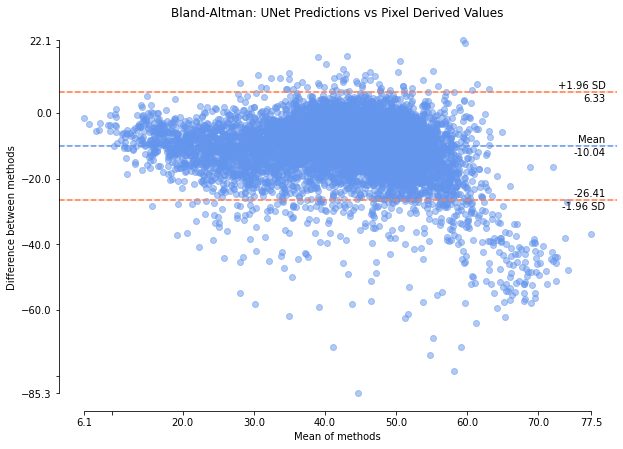

In [24]:
import pyCompare
pyCompare.blandAltman(
    final_filtered_results['EF_pixel'],    #the gt values
    final_filtered_results['EF_pred'],    # the predicted vals 
    confidenceInterval=95,  
    percentage=False,    
    title='Bland-Altman: UNet Predictions vs Pixel Derived Values',  
)


plt.show()

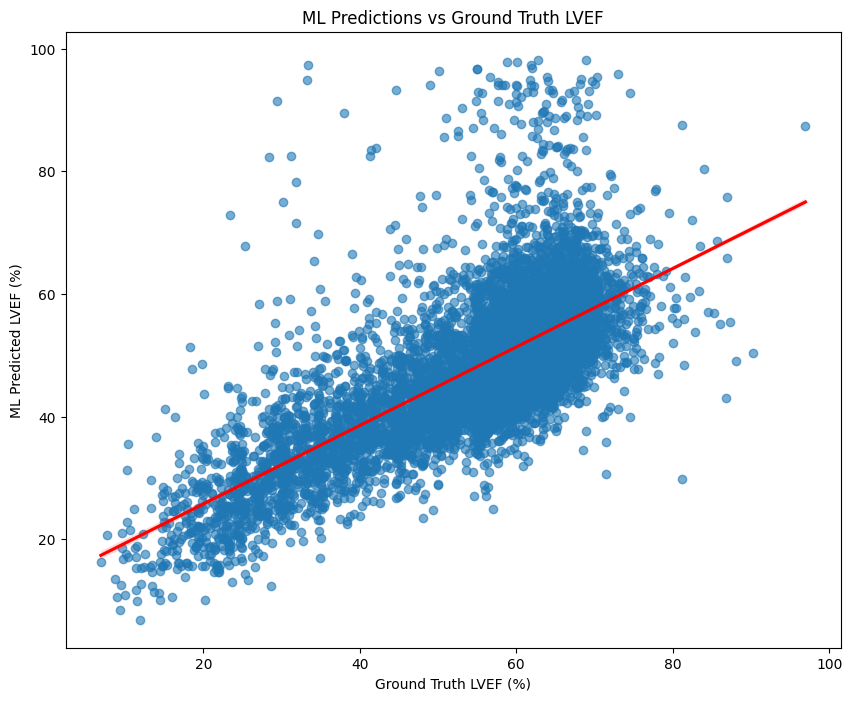

Correlation: 0.712


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# One line to create a beautiful regression plot
plt.figure(figsize=(10, 8))
sns.regplot(data=final_filtered_results, x='EF_gt_x', y='EF_pred', 
           scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})
plt.xlabel('Ground Truth LVEF (%)')
plt.ylabel('ML Predicted LVEF (%)')
plt.title('ML Predictions vs Ground Truth LVEF')
plt.show()

# Print correlation
correlation = final_filtered_results['EF_gt_x'].corr(final_filtered_results['EF_pred'])
print(f"Correlation: {correlation:.3f}")


# Compare results

In [ ]:
#load in both csv
import pandas as pd
preds = pd.read_csv("lvef_predictions_all_videos.csv") #to get prediction EDV, ESV, and EF
gt_and_pix = pd.read_csv("pixel_vs_gt_values.csv") #to get GT values and the pixel vals from masks


In [ ]:
#print cols to pick appropriate ones
print("Preds cols:", str(preds.columns))
print("GT/pix cols:", str(gt_and_pix.columns))

In [ ]:
#rename cols and left join on key
preds_renamed = preds.rename(columns={
    'Min_pixel': 'ESV_pred',
    'Max_pixel': 'EDV_pred',
    'EF_pixel' : 'EF_pred'
})



In [ ]:
# left join on key
final_df = preds_renamed.merge(right= gt_and_pix, on= 'Key', how='left')
print(final_df.columns)
final_df = final_df.dropna()

In [ ]:
#pick out relevant cols
final_df = final_df[['Key', 'ESV_pred', 'EDV_pred', 'EF_pred','ESV_pixel', 'EDV_pixel', 'EF_pixel', 'ESV_gt',
    'EDV_gt', 'EF_gt' ]]
print(final_df.columns)


#save the df 
final_df.to_csv("final_comparison_results.csv", index=False)
print(final_df.shape)

In [ ]:
final_df.head()

# Load final_result csv

In [ ]:
import pandas as pd
final_df = pd.read_csv("final_comparison_results.csv")

In [ ]:
#use bland-altman plot to measure the difference between averages
#using pycompare so install it first
import pyCompare
import matplotlib.pyplot as plt 

pyCompare.blandAltman(
    final_df['EF_gt'],    #the gt values
    final_df['EF_pred'],    # the predicted vals 
    confidenceInterval=95,  
    percentage=False,    
    title='Bland-Altman: UNet Predictions vs Ground Truth',  
)

plt.show()


In [ ]:
#Compare pred values against pixel values
pyCompare.blandAltman(
    final_df['EF_pixel'],    #the gt values
    final_df['EF_pred'],    # the predicted vals 
    confidenceInterval=95,  
    percentage=False,    
    title='Bland-Altman: UNet Predictions vs Pixel Derived Values',  
)


plt.show()

In [ ]:
#comprare ESV and EDV predictions
pyCompare.blandAltman(
    final_df['EDV_pixel'],    #the gt values
    final_df['EDV_pred'],    # the predicted vals 
    confidenceInterval=95,  
    percentage=False,    
    title='Bland-Altman: UNet Predictions vs Pixel Derived Values for EDV',  
)

#comprare ESV and EDV predictions
pyCompare.blandAltman(
    final_df['ESV_pixel'],    #the gt values
    final_df['ESV_pred'],    # the predicted vals 
    confidenceInterval=95,  
    percentage=False,    
    title='Bland-Altman: UNet Predictions vs Pixel Derived Values for ESV',  
)
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# One line to create a beautiful regression plot
plt.figure(figsize=(10, 8))
sns.regplot(data=final_df, x='EF_gt', y='EF_pred', 
           scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})
plt.xlabel('Ground Truth LVEF (%)')
plt.ylabel('ML Predicted LVEF (%)')
plt.title('ML Predictions vs Ground Truth LVEF')
plt.show()

# Print correlation
correlation = final_df['EF_gt'].corr(final_df['EF_pred'])
print(f"Correlation: {correlation:.3f}")


In [ ]:
plt.figure(figsize=(10, 8))
sns.regplot(data=final_df, x='EDV_pixel', y='EDV_pred', scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})
plt.xlabel('Number of GT Mask Pixels')
plt.ylabel('Number of Predicted Pixels')
plt.title('ML Predictions vs Ground Truth EDV')
plt.show()

# Print correlation
correlation = final_df['EDV_pixel'].corr(final_df['EDV_pred'])
print(f"Correlation: {correlation:.3f}")

In [ ]:
#ESV
plt.figure(figsize=(10, 8))
sns.regplot(data=final_df, x='ESV_pixel', y='ESV_pred', scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})
plt.xlabel('Number of GT Mask Pixels')
plt.ylabel('Number of Predicted Pixels')
plt.title('ML Predictions vs Ground Truth ESV')
plt.show()

# Print correlation
correlation = final_df['ESV_pixel'].corr(final_df['ESV_pred'])
print(f"Correlation: {correlation:.3f}")

## AI assisted BA plots when LVEF is stratified

In [ ]:
'''Hyperdynamic left ventricle = LV-Ejection Fraction (EF) greater than 70% 

Normal LV systolic function -= LVEF 50% to 70% (midpoint 60%) 

Mild LV systolic dysfunction = LV-EF 40% to 49% (midpoint 45%) 

Moderate LV systolic dysfunction = LV-EF 30% to 39% (midpoint 35%) 

Severe LV systolic dysfunction = LV-EF less than 30%.'''  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyCompare
import seaborn as sns

def stratify_lvef(ef_value):
    """
    Stratify LVEF into clinical categories based on ACC/AHA Guidelines
    """
    if ef_value > 70:
        return "Hyperdynamic (>70%)"
    elif ef_value >= 50:
        return "Normal (50-70%)"
    elif ef_value >= 40:
        return "Mild Dysfunction (40-49%)"
    elif ef_value >= 30:
        return "Moderate Dysfunction (30-39%)"
    else:
        return "Severe Dysfunction (<30%)"

def get_ef_category_color(category):
    """Get colors for each EF category"""
    colors = {
        "Hyperdynamic (>70%)": "#2E8B57",        # Sea Green
        "Normal (50-70%)": "#4169E1",            # Royal Blue  
        "Mild Dysfunction (40-49%)": "#FFD700",   # Gold
        "Moderate Dysfunction (30-39%)": "#FF8C00", # Dark Orange
        "Severe Dysfunction (<30%)": "#DC143C"    # Crimson
    }
    return colors.get(category, "#808080")

# Apply stratification to your data
clean_df = final_df.dropna().copy()

# Stratify based on Ground Truth LVEF
clean_df['EF_Category_GT'] = clean_df['EF_gt'].apply(stratify_lvef)
clean_df['EF_Category_Pred'] = clean_df['EF_pred'].apply(stratify_lvef)

print("📊 LVEF STRATIFICATION ANALYSIS")
print("="*40)

# Show distribution
category_counts = clean_df['EF_Category_GT'].value_counts()
print(f"\nDistribution by Ground Truth Categories:")
for category, count in category_counts.items():
    percentage = (count / len(clean_df)) * 100
    print(f"  {category}: {count} cases ({percentage:.1f}%)")

print(f"\nTotal cases: {len(clean_df)}")

In [ ]:
# Create comprehensive Bland-Altman plot with stratification
plt.figure(figsize=(15, 10))

# Calculate differences and means
differences = clean_df['EF_pred'] - clean_df['EF_gt']
means = (clean_df['EF_pred'] + clean_df['EF_gt']) / 2

# Overall statistics
mean_diff = np.mean(differences)
std_diff = np.std(differences, ddof=1)
upper_loa = mean_diff + 1.96 * std_diff
lower_loa = mean_diff - 1.96 * std_diff

# Create subplot layout
gs = plt.GridSpec(2, 3, height_ratios=[3, 1], width_ratios=[2, 2, 1])

# Main Bland-Altman plot
ax1 = plt.subplot(gs[0, :2])

# Plot points colored by category
categories = clean_df['EF_Category_GT'].unique()
for category in categories:
    mask = clean_df['EF_Category_GT'] == category
    color = get_ef_category_color(category)
    ax1.scatter(means[mask], differences[mask], 
               alpha=0.7, s=30, color=color, label=category, edgecolors='black', linewidth=0.5)

# Add Bland-Altman lines
ax1.axhline(mean_diff, color='red', linestyle='-', linewidth=2, label=f'Mean Bias: {mean_diff:.2f}%')
ax1.axhline(upper_loa, color='red', linestyle='--', linewidth=1.5, label=f'Upper LoA: {upper_loa:.2f}%')
ax1.axhline(lower_loa, color='red', linestyle='--', linewidth=1.5, label=f'Lower LoA: {lower_loa:.2f}%')
ax1.axhline(0, color='black', linestyle='-', alpha=0.3, linewidth=1)

# Formatting
ax1.set_xlabel('Mean of ML Predictions & Ground Truth (%)', fontsize=12)
ax1.set_ylabel('ML Predictions - Ground Truth (%)', fontsize=12)
ax1.set_title('Bland-Altman Plot: ML vs Ground Truth (Stratified by LVEF Category)', fontsize=14, fontweight='bold')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Category distribution pie chart
ax2 = plt.subplot(gs[0, 2])
colors_list = [get_ef_category_color(cat) for cat in category_counts.index]
wedges, texts, autotexts = ax2.pie(category_counts.values, labels=None, 
                                   colors=colors_list, autopct='%1.1f%%', startangle=90)
ax2.set_title('Distribution by\nGT Categories', fontsize=10, fontweight='bold')

# Error distribution histogram
ax3 = plt.subplot(gs[1, :2])
ax3.hist(differences, bins=30, alpha=0.7, edgecolor='black', color='lightblue')
ax3.axvline(mean_diff, color='red', linestyle='-', linewidth=2)
ax3.axvline(0, color='black', linestyle='--', alpha=0.5)
ax3.set_xlabel('Error (ML Predictions - Ground Truth) %', fontsize=10)
ax3.set_ylabel('Frequency', fontsize=10)
ax3.set_title('Error Distribution', fontsize=10, fontweight='bold')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()